In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import joblib
from scipy.stats import f_oneway, chi2_contingency
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [2]:
app_train = pd.read_csv("application_train.csv")

In [3]:
app_train.shape

(307511, 122)

In [4]:
app_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

### 1. Checking Duplicate Data

In [5]:
app_train.duplicated().sum()

0

In [6]:
# app_train.drop_duplicates()

### 2. Handling Missing Value

In [7]:
null = app_train.isna().sum().reset_index().rename(columns = {"index": "column_name", 0: "null_counts"}).sort_values(by = ["null_counts"])
null = null.set_index("column_name")
null["null_percentage"] = (null["null_counts"] / app_train.shape[0] * 100).round(2)
null

,null_counts,null_percentage
column_name,,
SK_ID_CURR,0,0.00
HOUR_APPR_PROCESS_START,0,0.00
REG_REGION_NOT_WORK_REGION,0,0.00
LIVE_REGION_NOT_WORK_REGION,0,0.00
REG_CITY_NOT_LIVE_CITY,0,0.00
...,...,...
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
COMMONAREA_MODE,214865,69.87


In [8]:
# Delete columns that have >50% missing values
del_column = list(null[null["null_percentage"] > 50].index)

app_train.drop(columns = del_column, inplace = True)

In [9]:
app_train.shape

(307511, 81)

In [10]:
app_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 81, dtype: object

#### 2a. Change The Dtype

In [11]:
app_train["TARGET"].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [12]:
# Numerical columns
list_num = list(app_train.select_dtypes(include = "number").columns)

# Categorical columns
list_cat = list(app_train.select_dtypes(include = "object").columns)

len(list_num), len(list_cat)

(68, 13)

In [13]:
num_to_cat = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 
              'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 
              'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
              'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
              'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
              'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
              'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 
              'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17', 
              'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [14]:
app_train[num_to_cat] = app_train[num_to_cat].astype(object)

In [15]:
# Update numerical and categorical columns
list_num = list(app_train.select_dtypes(include = "number").columns)
list_cat = list(app_train.select_dtypes(include = "object").columns)

len(list_num), len(list_cat)

(34, 47)

In [16]:
app_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 81, dtype: object

In [17]:
# Remove columns that have only 1 feature
nunique_value = app_train.apply(pd.Series.nunique)
single_value_cols = nunique_value[nunique_value == 1].index.tolist()
print(single_value_cols)

[]


In [18]:
# Missing in numerical data
app_train[list_num].isna().sum()

SK_ID_CURR                           0
TARGET                               0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
CNT_FAM_MEMBERS                      2
HOUR_APPR_PROCESS_START              0
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
YEARS_BEGINEXPLUATATION_AVG     150007
FLOORSMAX_AVG                   153020
YEARS_BEGINEXPLUATATION_MODE    150007
FLOORSMAX_MODE                  153020
YEARS_BEGINEXPLUATATION_MEDI    150007
FLOORSMAX_MEDI                  153020
TOTALAREA_MODE                  148431
OBS_30_CNT_SOCIAL_CIRCLE          1021
DEF_30_CNT_SOCIAL_CIRCLE          1021
OBS_60_CNT_SOCIAL_CIRCLE 

In [19]:
num_mean = app_train[list_num].mean()
num_mean.to_csv("save_files/num_mean.csv")

In [20]:
# Impute missing value in numerical data using "mean"
app_train[list_num] = app_train[list_num].fillna(num_mean)
app_train[list_num].isna().sum()

SK_ID_CURR                      0
TARGET                          0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
CNT_FAM_MEMBERS                 0
HOUR_APPR_PROCESS_START         0
EXT_SOURCE_2                    0
EXT_SOURCE_3                    0
YEARS_BEGINEXPLUATATION_AVG     0
FLOORSMAX_AVG                   0
YEARS_BEGINEXPLUATATION_MODE    0
FLOORSMAX_MODE                  0
YEARS_BEGINEXPLUATATION_MEDI    0
FLOORSMAX_MEDI                  0
TOTALAREA_MODE                  0
OBS_30_CNT_SOCIAL_CIRCLE        0
DEF_30_CNT_SOCIAL_CIRCLE        0
OBS_60_CNT_SOCIAL_CIRCLE        0
DEF_60_CNT_SOCIAL_CIRCLE        0
DAYS_LAST_PHONE_CHANGE          0
AMT_REQ_CREDIT_BUREAU_HOUR      0
AMT_REQ_CREDIT

In [21]:
# Missing in categorical data
app_train[list_cat].isna().sum()

NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
NAME_TYPE_SUITE                  1292
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE                          0
FLAG_EMAIL                          0
OCCUPATION_TYPE                 96391
REGION_RATING_CLIENT                0
REGION_RATING_CLIENT_W_CITY         0
WEEKDAY_APPR_PROCESS_START          0
REG_REGION_NOT_LIVE_REGION          0
REG_REGION_NOT_WORK_REGION          0
LIVE_REGION_NOT_WORK_REGION         0
REG_CITY_NOT_LIVE_CITY              0
REG_CITY_NOT_WORK_CITY              0
LIVE_CITY_NOT_WORK_CITY             0
ORGANIZATION_TYPE                   0
EMERGENCYSTA

In [22]:
dict_cat_mode = {}

for i in list_cat:
    mode_value = app_train[i].mode()[0]
    dict_cat_mode[i] = mode_value

In [23]:
# save
joblib.dump(dict_cat_mode, "save_files/dict_cat_mode.joblib")

['dict_cat_mode.joblib']

In [24]:
# Impute missing value in categorical data using "mode"
app_train[list_cat] = app_train[list_cat].fillna(dict_cat_mode)
app_train[list_cat].isna().sum()

NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
WEEKDAY_APPR_PROCESS_START     0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
ORGANIZATION_TYPE              0
EMERGENCYSTATE_MODE            0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUM

#### 2b. Exploring Numerical and Categorical Data

In [25]:
# CATEGORICAL DATA

In [26]:
for i in list_cat:
    print(app_train[i].value_counts())
    print("\n----------")

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

----------
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

----------
FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64

----------
FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64

----------
NAME_TYPE_SUITE
Unaccompanied      249818
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

----------
NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

----------
NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incompl

In [27]:
# Delete the document features that almost only have one value
delete_features = [i for i in list_cat if "DOCUMENT" in i]
not_remove = ["FLAG_DOCUMENT_8", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_3"] # the proporsion are better
delete_features = [i for i in delete_features if i not in not_remove]
delete_features.append("FLAG_MOBIL") # almost only have one value
delete_features

['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_MOBIL']

In [28]:
app_train.drop(columns = delete_features, inplace = True)

In [29]:
# Update categorical columns
list_cat = [i for i in list_cat if i not in delete_features]

In [30]:
((app_train.isna().sum()) > 0).sum()

0

In [31]:
app_train.shape

(307511, 63)

In [32]:
# "XNA" in CODE_GENDER replace by NAN
# "Unknown" in NAME_FAMILY_STATUS replace by NAN
# "XNA" in ORGANIZATION_TYPE replace by "Other"

app_train["CODE_GENDER"].replace("XNA", np.nan, inplace = True)
app_train["NAME_FAMILY_STATUS"].replace("Unknown", np.nan, inplace = True)
app_train["ORGANIZATION_TYPE"].replace("XNA", "Other", inplace = True)

In [33]:
((app_train.isna().sum()) > 0).sum()

2

In [34]:
# Impute missing value in categorical data using "mode"
app_train["CODE_GENDER"] = app_train["CODE_GENDER"].fillna(app_train["CODE_GENDER"].mode()[0])
app_train["NAME_FAMILY_STATUS"] = app_train["NAME_FAMILY_STATUS"].fillna(app_train["NAME_FAMILY_STATUS"].mode()[0])
app_train[list_cat].isna().sum()

NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
WEEKDAY_APPR_PROCESS_START     0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
ORGANIZATION_TYPE              0
EMERGENCYSTATE_MODE            0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_8                0
dtype: int64

In [35]:
app_train[list_cat].describe().T

,count,mean,std,min,25%,50%,75%,max
FLAG_EMP_PHONE,307511.0,0.819889,0.384280,0.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,307511.0,0.199368,0.399526,0.0,0.0,0.0,0.0,1.0
FLAG_CONT_MOBILE,307511.0,0.998133,0.043164,0.0,1.0,1.0,1.0,1.0
FLAG_PHONE,307511.0,0.281066,0.449521,0.0,0.0,0.0,1.0,1.0
FLAG_EMAIL,307511.0,0.056720,0.231307,0.0,0.0,0.0,0.0,1.0
REGION_RATING_CLIENT,307511.0,2.052463,0.509034,1.0,2.0,2.0,2.0,3.0
REGION_RATING_CLIENT_W_CITY,307511.0,2.031521,0.502737,1.0,2.0,2.0,2.0,3.0
REG_REGION_NOT_LIVE_REGION,307511.0,0.015144,0.122126,0.0,0.0,0.0,0.0,1.0
REG_REGION_NOT_WORK_REGION,307511.0,0.050769,0.219526,0.0,0.0,0.0,0.0,1.0
LIVE_REGION_NOT_WORK_REGION,307511.0,0.040659,0.197499,0.0,0.0,0.0,0.0,1.0


In [36]:
# NUMERICAL DATA

In [37]:
app_train[list_num].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.52,102790.18,100002.0,189145.50,278202.00,367142.50,4.562550e+05
TARGET,307511.0,0.08,0.27,0.0,0.00,0.00,0.00,1.000000e+00
CNT_CHILDREN,307511.0,0.42,0.72,0.0,0.00,0.00,1.00,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.92,237123.15,25650.0,112500.00,147150.00,202500.00,1.170000e+08
AMT_CREDIT,307511.0,599026.00,402490.78,45000.0,270000.00,513531.00,808650.00,4.050000e+06
AMT_ANNUITY,307511.0,27108.57,14493.45,1615.5,16524.00,24903.00,34596.00,2.580255e+05
AMT_GOODS_PRICE,307511.0,538396.21,369279.43,40500.0,238500.00,450000.00,679500.00,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.02,0.01,0.0,0.01,0.02,0.03,7.000000e-02
DAYS_BIRTH,307511.0,-16037.00,4363.99,-25229.0,-19682.00,-15750.00,-12413.00,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.05,141275.77,-17912.0,-2760.00,-1213.00,-289.00,3.652430e+05


In [38]:
app_train.shape

(307511, 63)

In [39]:
app_train.columns.duplicated().sum()

0

### 3. Feature Selection

In [40]:
# CORRELATION
# Numerical & Categorical -> ANOVA
# Categorical & Categorical -> Chi Square

#### 3a. ANOVA

In [42]:
# Assumption (H0) is between 2 variables are NOT correlated
# Reject H0 if p-value < 0.05 (Reject = correlated)

category_group = app_train.groupby("TARGET")["CNT_CHILDREN"].apply(list)
anova_result = f_oneway(*category_group)
print("P-value of Anova:", anova_result[1])

P-value of Anova: 1.9224915500910093e-26


In [43]:
dict_anova = {}
for i in list_num:
    category_group = app_train.groupby("TARGET")[i].apply(list)
    pvalue_anova = f_oneway(*category_group)[1]
    dict_anova[i] = pvalue_anova

/Users/wanda/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [44]:
dict_anova

{'SK_ID_CURR': 0.24231496893115526,
 'TARGET': 0.0,
 'CNT_CHILDREN': 1.9224915500910093e-26,
 'AMT_INCOME_TOTAL': 0.02723796087829524,
 'AMT_CREDIT': 1.1474602724260586e-63,
 'AMT_ANNUITY': 1.1815936484710046e-12,
 'AMT_GOODS_PRICE': 4.1013948936918764e-107,
 'REGION_POPULATION_RELATIVE': 9.582701564553064e-95,
 'DAYS_BIRTH': 0.0,
 'DAYS_EMPLOYED': 3.6311730827265075e-137,
 'DAYS_REGISTRATION': 6.0365534541554926e-120,
 'DAYS_ID_PUBLISH': 2.527523814198052e-179,
 'CNT_FAM_MEMBERS': 2.4485092616990623e-07,
 'HOUR_APPR_PROCESS_START': 5.826823528542842e-41,
 'EXT_SOURCE_2': 0.0,
 'EXT_SOURCE_3': 0.0,
 'YEARS_BEGINEXPLUATATION_AVG': 0.00030080320356455637,
 'FLOORSMAX_AVG': 8.833929163271674e-59,
 'YEARS_BEGINEXPLUATATION_MODE': 0.0007857771365762672,
 'FLOORSMAX_MODE': 8.734258610027192e-57,
 'YEARS_BEGINEXPLUATATION_MEDI': 0.00020462635987650627,
 'FLOORSMAX_MEDI': 3.583899853939172e-58,
 'TOTALAREA_MODE': 4.520533398298308e-34,
 'OBS_30_CNT_SOCIAL_CIRCLE': 4.2083174080918836e-07,
 'DEF

#### 3b. Chi Square

In [45]:
# Assumption (H0) is between 2 variables are NOT correlated
# Reject H0 if p-value < 0.05 (Reject = correlated)

crosstab_result = pd.crosstab(index = app_train["CODE_GENDER"], 
                              columns = app_train["TARGET"])
chisquare_result = chi2_contingency(crosstab_result)
print("P-value of Chi Square:", chisquare_result[1])

P-value of Chi Square: 4.183493188620687e-202


In [46]:
dict_chisquare = {}
for i in list_cat:
    crosstab_result = pd.crosstab(index = app_train[i], 
                                  columns = app_train["TARGET"])
    pvalue_chisquare = chi2_contingency(crosstab_result)[1]
    dict_chisquare[i] = pvalue_chisquare

In [47]:
dict_chisquare

{'NAME_CONTRACT_TYPE': 1.0235150721172847e-65,
 'CODE_GENDER': 4.183493188620687e-202,
 'FLAG_OWN_CAR': 9.330994431109667e-34,
 'FLAG_OWN_REALTY': 0.0006681470317545887,
 'NAME_TYPE_SUITE': 1.669680344640335e-05,
 'NAME_INCOME_TYPE': 1.9281456056861122e-266,
 'NAME_EDUCATION_TYPE': 2.4476812052198174e-219,
 'NAME_FAMILY_STATUS': 6.983958115483933e-108,
 'NAME_HOUSING_TYPE': 1.0990890032617707e-88,
 'FLAG_EMP_PHONE': 2.5306059279614537e-143,
 'FLAG_WORK_PHONE': 2.6758000919452704e-56,
 'FLAG_CONT_MOBILE': 0.8976989816319643,
 'FLAG_PHONE': 9.489418049556951e-40,
 'FLAG_EMAIL': 0.3366632895181666,
 'OCCUPATION_TYPE': 3.4203518801583733e-243,
 'REGION_RATING_CLIENT': 1.8283164955910817e-232,
 'REGION_RATING_CLIENT_W_CITY': 5.05571529094165e-249,
 'WEEKDAY_APPR_PROCESS_START': 0.01744736931389504,
 'REG_REGION_NOT_LIVE_REGION': 0.0021769580022904804,
 'REG_REGION_NOT_WORK_REGION': 0.0001258375420219184,
 'LIVE_REGION_NOT_WORK_REGION': 0.12192447948152679,
 'REG_CITY_NOT_LIVE_CITY': 1.07523

In [48]:
len(dict_anova), len(dict_chisquare)

(34, 29)

In [49]:
# Combine p_value from ANOVA and Chi Square
pvalue_all = dict(dict_anova)
pvalue_all.update(dict_chisquare)
len(pvalue_all)

63

In [50]:
# Just select variables that have correlation with "TARGET"
correlated_var = []
for var, pvalue in pvalue_all.items():
    if pvalue <= 0.05:
        correlated_var.append(var)
        
correlated_var.insert(0, "SK_ID_CURR")

In [51]:
len(correlated_var)

56

In [52]:
correlated_var

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'CNT_FAM_MEMBERS',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLOORSMAX_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'W

In [53]:
# Update numerical and categorical columns
list_num = [i for i in list_num if i in correlated_var]
list_cat = [i for i in list_cat if i in correlated_var]

# save
joblib.dump(list_num, "save_files/list_num.joblib")
joblib.dump(list_cat, "save_files/list_cat.joblib")

['list_cat.joblib']

In [54]:
app_train = app_train[correlated_var]
app_train.shape

(307511, 56)

In [55]:
app_train.to_csv("save_files/data_train_with_correlated_var.csv", index = False)

### 4. Handling Categorical Data

In [104]:
app_train_ok = pd.read_csv("save_files/data_train_with_correlated_var.csv")
app_train_ok

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,Business Entity Type 3,No,1,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0,School,No,1,0,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,Government,No,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,Business Entity Type 3,No,1,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,1,1,Religion,No,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,0,0,0,0,0,Services,No,0,0,1
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,0,0,0,0,0,Other,No,1,0,0
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,0,0,0,1,1,School,No,1,0,0
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,0,0,1,1,0,Business Entity Type 1,No,1,0,0


In [105]:
app_train_ok.dtypes

SK_ID_CURR                        int64
TARGET                            int64
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
CNT_FAM_MEMBERS                 float64
HOUR_APPR_PROCESS_START           int64
EXT_SOURCE_2                    float64
EXT_SOURCE_3                    float64
YEARS_BEGINEXPLUATATION_AVG     float64
FLOORSMAX_AVG                   float64
YEARS_BEGINEXPLUATATION_MODE    float64
FLOORSMAX_MODE                  float64
YEARS_BEGINEXPLUATATION_MEDI    float64
FLOORSMAX_MEDI                  float64
TOTALAREA_MODE                  float64
OBS_30_CNT_SOCIAL_CIRCLE        float64
DEF_30_CNT_SOCIAL_CIRCLE        float64


In [58]:
list_cat_ok = joblib.load("save_files/list_cat.joblib")
app_train_ok[list_cat_ok] = app_train_ok[list_cat_ok].astype(object)

In [106]:
# Use Frequency Encoding
encoder_dict = {}

for var in list_cat_ok:
    encoder_dict[var] = (app_train_ok[var].value_counts() / len(app_train_ok)).to_dict()

In [107]:
encoder_dict

{'NAME_CONTRACT_TYPE': {'Cash loans': 0.9047871458256778,
  'Revolving loans': 0.09521285417432222},
 'CODE_GENDER': {'F': 0.6583569368250242, 'M': 0.34164306317497584},
 'FLAG_OWN_CAR': {'N': 0.6598918412674668, 'Y': 0.34010815873253314},
 'FLAG_OWN_REALTY': {'Y': 0.6936727466659729, 'N': 0.30632725333402705},
 'NAME_TYPE_SUITE': {'Unaccompanied': 0.8123871991571033,
  'Family': 0.13056118317718715,
  'Spouse, partner': 0.03697428709867289,
  'Children': 0.010624010198009176,
  'Other_B': 0.0057558916591601604,
  'Other_A': 0.002816159421939378,
  'Group of people': 0.0008812692879279115},
 'NAME_INCOME_TYPE': {'Working': 0.5163197414076245,
  'Commercial associate': 0.2328924818949566,
  'Pensioner': 0.18003258420024,
  'State servant': 0.07057633710664009,
  'Unemployed': 7.154215621555002e-05,
  'Student': 5.8534491449086374e-05,
  'Businessman': 3.2519161916159095e-05,
  'Maternity leave': 1.6259580958079547e-05},
 'NAME_EDUCATION_TYPE': {'Secondary / secondary special': 0.7101892

In [108]:
# Apply the encoder value in the new columns
for var in list_cat_ok:
    app_train_ok[var] = app_train_ok[var].map(encoder_dict[var])

In [109]:
app_train_ok.head(2)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0.984856,0.949231,0.921827,0.769546,0.820445,0.221104,0.99243,0.710023,0.911945,0.918624
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0.984856,0.949231,0.921827,0.769546,0.820445,0.028919,0.99243,0.710023,0.911945,0.918624


In [110]:
# Save the "encoder_dict"
joblib.dump(encoder_dict, "save_files/encoder_dict.joblib")

['encoder_dict.joblib']

In [111]:
app_train_ok = app_train_ok.drop("SK_ID_CURR", axis = 1)
app_train_ok.head(2)

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8
0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0.984856,0.949231,0.921827,0.769546,0.820445,0.221104,0.99243,0.710023,0.911945,0.918624
1,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0.984856,0.949231,0.921827,0.769546,0.820445,0.028919,0.99243,0.710023,0.911945,0.918624


### 5. Handling Imbalanced Data

In [112]:
# Percentage of each class
app_train_ok["TARGET"].value_counts() / len(app_train_ok) * 100

TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64

In [113]:
X = app_train_ok.drop("TARGET", axis = 1)
y = app_train_ok["TARGET"]

In [114]:
len(X.columns)

54

In [115]:
y.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [116]:
# Undersampling the majority class
undersample = RandomUnderSampler(random_state = 42)
X_res, y_res = undersample.fit_resample(X, y)

In [117]:
y_res.value_counts()

TARGET
0    24825
1    24825
Name: count, dtype: int64

### 6. Feature Scaling

In [118]:
X_res.shape

(49650, 54)

In [119]:
X_res.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [120]:
list_num_ok = joblib.load("save_files/list_num.joblib")

In [121]:
len(list_num_ok)

30

In [122]:
list_num_ok.remove("SK_ID_CURR")
list_num_ok.remove("TARGET")
list_num_ok

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'CNT_FAM_MEMBERS',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLOORSMAX_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [123]:
X_res_stand = X_res.copy()

In [124]:
# Use Standardization

In [125]:
# Apply standardization on numerical features
dict_standardization = {}

for i in list_num_ok:
    # fit on training data column
    scale = StandardScaler()
    scale.fit(X_res_stand[[i]])

    # save the scaler object per variable
    joblib.dump(scale, "save_files/joblib_standardization/" + i + ".joblib")
    dict_standardization[i] = "save_files/joblib_standardization/" + i + ".joblib"
    
    # transform the training data column
    X_res_stand[i] = scale.transform(X_res_stand[[i]])

In [126]:
# save
joblib.dump(dict_standardization, "save_files/dict_standardization.joblib")

['dict_standardization.joblib']

In [127]:
dict_standardization

{'CNT_CHILDREN': 'joblib_standardization/CNT_CHILDREN.joblib',
 'AMT_INCOME_TOTAL': 'joblib_standardization/AMT_INCOME_TOTAL.joblib',
 'AMT_CREDIT': 'joblib_standardization/AMT_CREDIT.joblib',
 'AMT_ANNUITY': 'joblib_standardization/AMT_ANNUITY.joblib',
 'AMT_GOODS_PRICE': 'joblib_standardization/AMT_GOODS_PRICE.joblib',
 'REGION_POPULATION_RELATIVE': 'joblib_standardization/REGION_POPULATION_RELATIVE.joblib',
 'DAYS_BIRTH': 'joblib_standardization/DAYS_BIRTH.joblib',
 'DAYS_EMPLOYED': 'joblib_standardization/DAYS_EMPLOYED.joblib',
 'DAYS_REGISTRATION': 'joblib_standardization/DAYS_REGISTRATION.joblib',
 'DAYS_ID_PUBLISH': 'joblib_standardization/DAYS_ID_PUBLISH.joblib',
 'CNT_FAM_MEMBERS': 'joblib_standardization/CNT_FAM_MEMBERS.joblib',
 'HOUR_APPR_PROCESS_START': 'joblib_standardization/HOUR_APPR_PROCESS_START.joblib',
 'EXT_SOURCE_2': 'joblib_standardization/EXT_SOURCE_2.joblib',
 'EXT_SOURCE_3': 'joblib_standardization/EXT_SOURCE_3.joblib',
 'YEARS_BEGINEXPLUATATION_AVG': 'joblib_

In [128]:
X_res_stand.head(2)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8
201622,0.751970,0.235286,1.375052,0.403220,1.695226,-0.141886,0.860965,-0.413916,1.240573,-0.299187,...,0.984856,0.949231,0.921827,0.769546,0.820445,0.003860,0.99243,0.710023,0.911945,0.918624
8728,-0.591704,0.193017,0.366399,0.669629,0.588342,2.002004,-1.782893,2.354147,0.143480,-0.844557,...,0.984856,0.949231,0.921827,0.769546,0.820445,0.234323,0.99243,0.289977,0.911945,0.918624


In [129]:
# Will use "X_res_stand" and "y_res"
len(X_res_stand), len(y_res)

(49650, 49650)

In [130]:
# Combine "X_res_stand" and "y_res" to save the data
data_resample = pd.concat(objs = [X_res_stand, y_res], axis = 1)
data_resample.head(2)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,TARGET
201622,0.751970,0.235286,1.375052,0.403220,1.695226,-0.141886,0.860965,-0.413916,1.240573,-0.299187,...,0.949231,0.921827,0.769546,0.820445,0.003860,0.99243,0.710023,0.911945,0.918624,0
8728,-0.591704,0.193017,0.366399,0.669629,0.588342,2.002004,-1.782893,2.354147,0.143480,-0.844557,...,0.949231,0.921827,0.769546,0.820445,0.234323,0.99243,0.289977,0.911945,0.918624,0


In [131]:
data_resample.shape

(49650, 55)

In [132]:
data_resample.to_csv("save_files/data_final_resample_standardization.csv", index = False)

### 7. Modeling and Evaluation

#### 7a. Logistic Regression

In [150]:
df = pd.read_csv("save_files/data_final_resample_standardization.csv")
df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,TARGET
0,0.751970,0.235286,1.375052,0.403220,1.695226,-0.141886,0.860965,-0.413916,1.240573,-0.299187,...,0.949231,0.921827,0.769546,0.820445,0.003860,0.99243,0.710023,0.911945,0.918624,0
1,-0.591704,0.193017,0.366399,0.669629,0.588342,2.002004,-1.782893,2.354147,0.143480,-0.844557,...,0.949231,0.921827,0.769546,0.820445,0.234323,0.99243,0.289977,0.911945,0.918624,0
2,0.751970,-0.060600,-0.582922,-0.649225,-0.453432,-0.696247,-0.850283,-0.434673,0.067698,0.207228,...,0.949231,0.921827,0.769546,0.820445,0.221104,0.99243,0.289977,0.911945,0.918624,0
3,-0.591704,-0.145139,-0.938917,-1.204133,-0.844097,-0.370580,1.172374,-0.417441,-0.002838,-0.109034,...,0.949231,0.921827,0.230454,0.179555,0.124913,0.99243,0.710023,0.911945,0.918624,0
4,-0.591704,0.218378,3.214360,1.821318,3.713662,-1.264537,0.777275,-0.433341,0.828726,-0.933692,...,0.949231,0.921827,0.769546,0.820445,0.010952,0.99243,0.710023,0.911945,0.918624,0


In [151]:
X = df.drop("TARGET", axis = 1)
y = df["TARGET"]

In [152]:
logistic_classifier = LogisticRegression(random_state = 42)
param_grid = {"solver": ["newton-cg", "lbfgs", "liblinear"], 
              "penalty": ["l2"], 
              "C": [100, 10, 1.0, 0.1, 0.01]}

grid_search_1 = GridSearchCV(logistic_classifier, param_grid, n_jobs = 2, scoring = "f1", cv = 5)
grid_search_1.fit(X, y)

/Users/wanda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wanda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

/Users/wanda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wanda/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=2,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1')

In [153]:
print("Best Params: ", grid_search_1.best_params_)
print("Best Score: ", grid_search_1.best_score_)

Best Params:  {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score:  0.6748808765269741


In [154]:
# save the Logistic classifier model
joblib.dump(grid_search_1, "save_files/logistic_classifier_model.joblib")

['logistic_classifier_model.joblib']

#### 7b. Random Forest

In [155]:
forest_classifier = RandomForestClassifier(random_state = 42)
param_grid = {"n_estimators": [10, 100, 1000], 
              "max_features": ["sqrt", "log2"]}

grid_search_2 = GridSearchCV(forest_classifier, param_grid, n_jobs = 2, scoring = "f1", cv = 5)
grid_search_2.fit(X, y)

/Users/wanda/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=2,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             scoring='f1')

In [156]:
print("Best Params: ", grid_search_2.best_params_)
print("Best Score: ", grid_search_2.best_score_)

Best Params:  {'max_features': 'log2', 'n_estimators': 1000}
Best Score:  0.6756810207415448


In [157]:
# save the Random Forest classifier model
joblib.dump(grid_search_2, "save_files/randomforest_classifier_model.joblib")

['randomforest_classifier_model.joblib']

### 8. Remodeling Using Random Forest Features Importance 

In [159]:
forest_classifier1 = RandomForestClassifier(random_state = 42, 
                                            max_features = "log2",
                                            n_estimators = 1000)

forest_classifier1.fit(X, y)

RandomForestClassifier(max_features='log2', n_estimators=1000, random_state=42)

Text(0.5, 0, 'Random Forest Feature Importance')

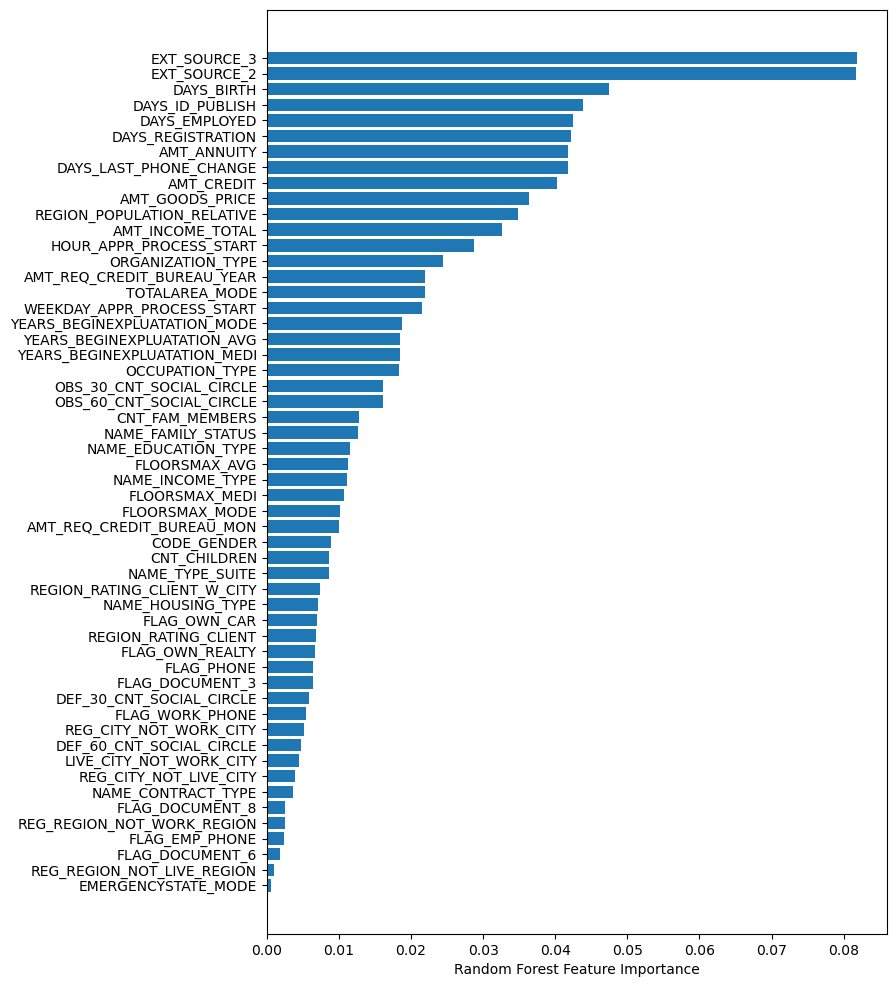

In [177]:
sorted_idx = forest_classifier1.feature_importances_.argsort()

plt.figure(figsize = (8, 12))
plt.barh(X.columns[sorted_idx], forest_classifier1.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [170]:
# Select features importance using SelectFromModel
sel = SelectFromModel(RandomForestClassifier(random_state = 42, 
                                            max_features = "log2",
                                            n_estimators = 1000))
sel.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(max_features='log2',
                                                 n_estimators=1000,
                                                 random_state=42))

In [172]:
selected_feat = X.columns[(sel.get_support())]
len(selected_feat)

18

In [181]:
selected_feat

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_MODE',
       'TOTALAREA_MODE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [182]:
# Update the X data
X_sel = X[selected_feat]
y_sel = y

#### 8a. Remodeling data based on selected features (Logistic Regression)

In [183]:
logistic_classifier_sel = LogisticRegression(random_state = 42)
param_grid = {"solver": ["newton-cg", "lbfgs", "liblinear"], 
              "penalty": ["l2"], 
              "C": [100, 10, 1.0, 0.1, 0.01]}

grid_search_3 = GridSearchCV(logistic_classifier_sel, param_grid, n_jobs = 2, scoring = "f1", cv = 5)
grid_search_3.fit(X_sel, y_sel)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=2,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1')

In [184]:
print("Best Params: ", grid_search_3.best_params_)
print("Best Score: ", grid_search_3.best_score_)

Best Params:  {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score:  0.6588315547763948


In [185]:
# save the Logistic classifier model (selected features)
joblib.dump(grid_search_3, "save_files/logistic_classifier_model_sel.joblib")

['logistic_classifier_model_sel.joblib']

#### 8b. Remodeling data based on selected features (Random Forest)

In [186]:
forest_classifier_sel = RandomForestClassifier(random_state = 42)
param_grid = {"n_estimators": [10, 100, 1000], 
              "max_features": ["sqrt", "log2"]}

grid_search_4 = GridSearchCV(forest_classifier_sel, param_grid, n_jobs = 2, scoring = "f1", cv = 5)
grid_search_4.fit(X_sel, y_sel)

/Users/wanda/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=2,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             scoring='f1')

In [187]:
print("Best Params: ", grid_search_4.best_params_)
print("Best Score: ", grid_search_4.best_score_)

Best Params:  {'max_features': 'sqrt', 'n_estimators': 1000}
Best Score:  0.6648048412532948


In [188]:
# save the Random Forest classifier model (selected features)
joblib.dump(grid_search_4, "save_files/randomforest_classifier_model_sel.joblib")

['randomforest_classifier_model_sel.joblib']

In [ ]:
# Will use "randomforest_classifier_model_sel.joblib" for modeling the input data in the future